In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
import random
import sys

In [17]:
print("PyTorch Version:", torch.__version__)
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Device Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

PyTorch Version: 2.8.0+cu128
CUDA Available:  True
CUDA Device Name:  NVIDIA GeForce RTX 5070 Laptop GPU


# Verilerin Okunması

In [18]:
tumor = []
healthy = []

for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

In [19]:
for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [20]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [21]:
healthy.shape[1]

128

In [22]:
np.random.choice(5,3, replace=False)

array([1, 0, 4])

# Beyin MR Görüntülerini Görselleştirme

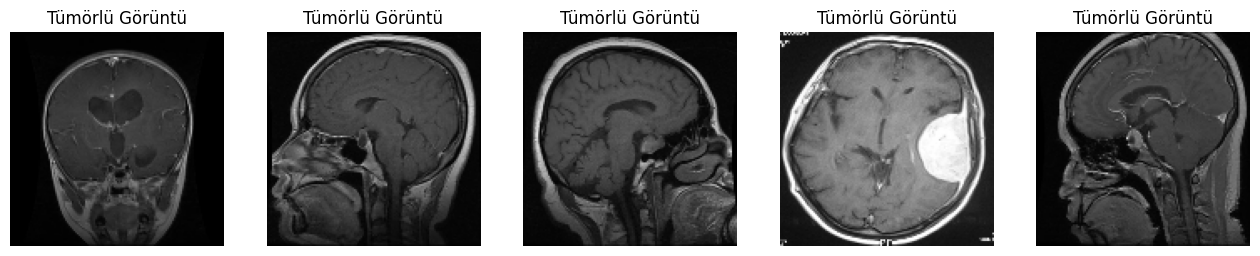

In [23]:
def plot_random(num=5, health=True):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    
    if health:
        for i in range(num):
            plt.subplot(1, num, i+1)
            plt.title("Sağlıklı Görüntü")
            plt.imshow(healthy_imgs[i])
            plt.axis("off")
    else:
        for i in range(num):
            plt.subplot(1, num, i+1)
            plt.title("Tümörlü Görüntü")
            plt.imshow(tumor_imgs[i])
            plt.axis("off")

plot_random(health=False)

# Torch Veriseti Sınıfı Oluşturma

In [24]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    
    def __len__(self):
        raise NotImplementedError
    
    def __add__(self, other):
        return ConcatDataset([self, other])

# Özel MR Veriseti Sınıfı Oluşturma

In [25]:
class MRI(Dataset):
    def __init__(self):
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        self.mode = 'train'

        tumor = []
        healthy = []

        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.transpose(2, 0, 1)
            tumor.append(img)

        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.transpose(2, 0, 1)
            healthy.append(img)          

        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label), axis=0)

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.images, self.labels, test_size=0.2, random_state=42)

    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
        else:
            return None

    def __getitem__(self, index):
        if self.mode == 'train':
            return {"image":self.X_train[index], "label":self.y_train[index]}
        elif self.mode == 'val':
            return {"image":self.X_val[index], "label": self.y_val[index]}
        else:
            return None
    
    def normalize(self):
        self.images = self.images / 255.0
        
    

In [26]:
mri = MRI()
mri.normalize()
mri.train_val_split()

print("Veri Sayısı: ", len(mri))

Veri Sayısı:  5814


In [27]:
print(mri.images.shape)

(7268, 3, 128, 128)


In [28]:
train_dataloader = DataLoader(mri, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri, batch_size=32, shuffle=False)

# Model Oluşturmak

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def _get_conv_output_size(self):
        x = torch.randn(1, 3, 128, 128)
        x = self.cnn_model(x)
        self._to_linear = x.view(1, -1).shape[1]

    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),


            #son ekleme
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self._to_linear = None
        self._get_conv_output_size()

        self.fc_model = nn.Sequential(
            nn.Linear(in_features=self._to_linear, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = torch.flatten(x, 1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

In [30]:
device = torch.device('cuda')
model = CNN().to(device)

In [31]:
eta = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=1e-4)

In [32]:
epoch_train_loss = []
epoch_val_loss = []

In [33]:
patience = 10
best_val_loss = float('inf')
counter = 0


for epoch in range(1, 100):
    train_losses = []
    model.train()
    mri.mode = 'train'
    for D in train_dataloader:
        optimizer.zero_grad()

        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    val_losses = []
    model.eval()
    mri.mode = 'val'
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)

            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            
            val_losses.append(loss.item())
        epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping! Validation loss iyileşmedi.")
            break

Train Epoch: 10	Train Loss: 0.047009	Val Loss: 0.173293
Train Epoch: 20	Train Loss: 0.003971	Val Loss: 0.078865
Early stopping! Validation loss iyileşmedi.


Text(0, 0.5, 'Loss')

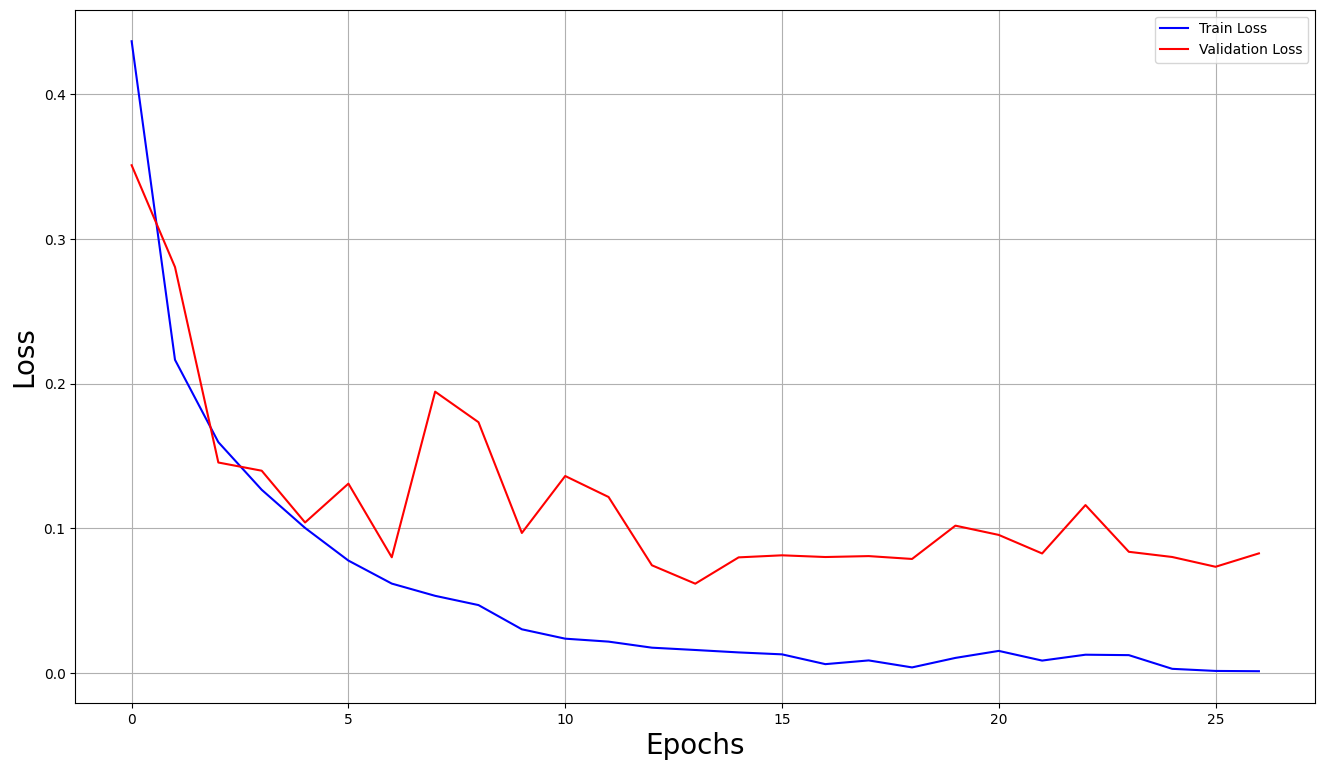

In [34]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c="b", label="Train Loss")
plt.plot(epoch_val_loss, c="r", label="Validation Loss")

plt.legend()
plt.grid()

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

In [35]:
model.eval()
outputs = []
y_true = []

device = torch.device("cuda")

with torch.no_grad():
    for D in val_dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [36]:
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [37]:
def threshold(scores, threshold=0.5, minimum=0, maximum=1.0):
    x = np.array(list(scores))
    
    x[x>=threshold] = maximum
    x[x<threshold] = minimum
    
    return x

In [38]:
print("Model Doğruluk Skoru: ", accuracy_score(y_true, threshold(outputs)))

cm = confusion_matrix(y_true, threshold(outputs))

print("\nHATALI TAHMİNLER")
print("Tümör olarak değerlendirilen sağlıklı veriler: ", cm[1][0])
print("Sağlıklı olarak değerlendirilen tümörlü veriler: ", cm[0][1], "\n")

print("DOĞRU TAHMİNLER")
print("Sağlıklı olarak değerlendirilen sağlıklı veriler: ", cm[0][0])
print("Tümörlü olarak değerlendirilen tümörlü veriler: ", cm[1][1])

Model Doğruluk Skoru:  0.984869325997249

HATALI TAHMİNLER
Tümör olarak değerlendirilen sağlıklı veriler:  11
Sağlıklı olarak değerlendirilen tümörlü veriler:  11 

DOĞRU TAHMİNLER
Sağlıklı olarak değerlendirilen sağlıklı veriler:  402
Tümörlü olarak değerlendirilen tümörlü veriler:  1030


[Text(0, 0.5, 'Sağlıklı'), Text(0, 1.5, 'Tümörlü')]

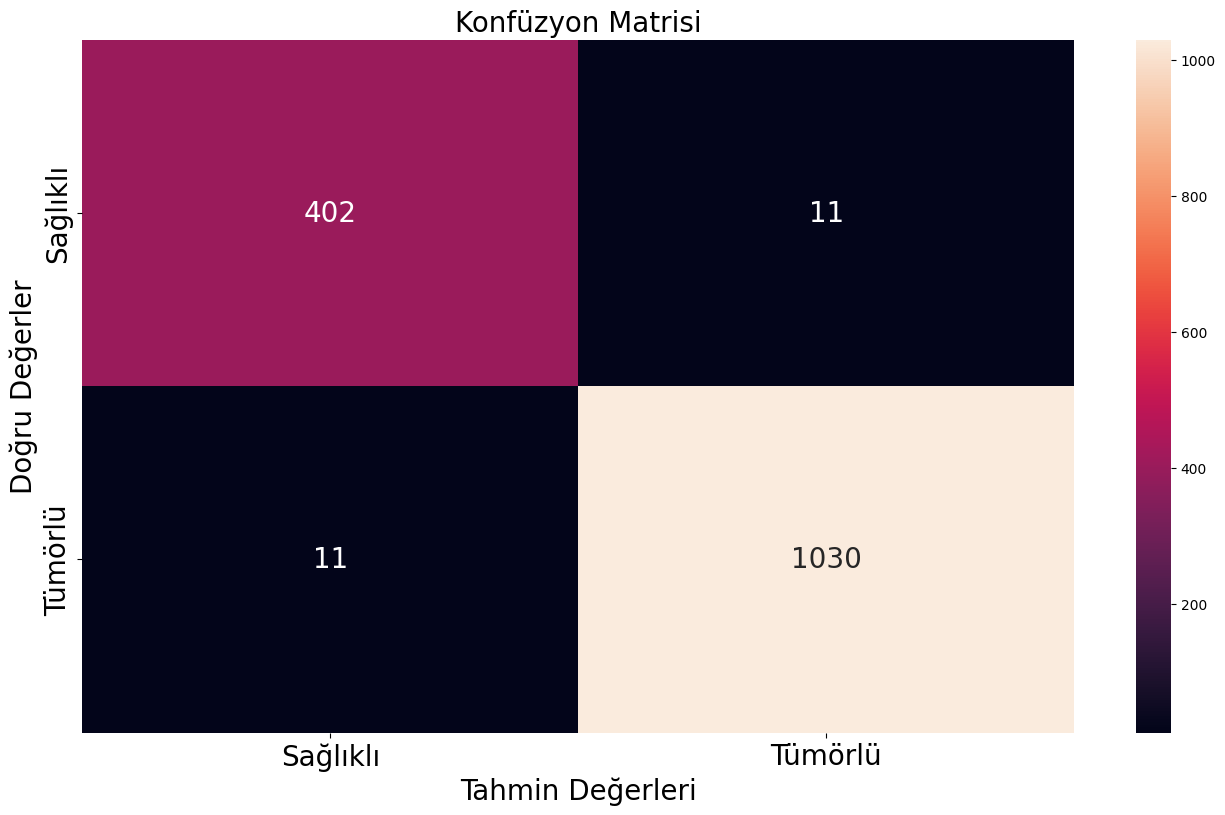

In [39]:
import seaborn as sns

plt.figure(figsize=(16,9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax, annot_kws={"size":20})

ax.set_xlabel("Tahmin Değerleri", fontsize=20)
ax.set_ylabel("Doğru Değerler", fontsize=20)
ax.set_title("Konfüzyon Matrisi", fontsize=20)

ax.xaxis.set_ticklabels(["Sağlıklı", "Tümörlü"], fontsize=20)
ax.yaxis.set_ticklabels(["Sağlıklı", "Tümörlü"], fontsize=20 )